# Quantium Virtual Internship - Retail Strategy and Analytics - Task 1

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from scipy.stats import ttest_ind

## Exploratory Data Analysis

### Transaction Data

In [3]:
# Import transaction data
transaction_data = pd.read_csv('data/QVI_transaction_data.csv')
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [4]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


From this summary we can see that there aren't any null values.

The date column, however, needs to be converted to a datetime format.

In [5]:
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], unit='D', origin='1899-12-30')

Explore the products in the dataset:

In [6]:
prods = transaction_data['PROD_NAME'].unique()

print("Number of products:", len(prods))

prods[:10]

Number of products: 114


array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G'], dtype=object)

We will use a wordcloud to visualise the words that appear in the product names:

(-0.5, 2999.5, 2499.5, -0.5)

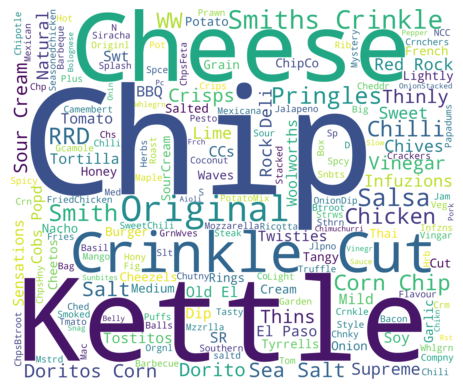

In [7]:
def valid_word(word):
    return not (word in ['', '&'] or any(char.isdigit() for char in word))

words = [word for prodname in prods for word in prodname.split(" ") if valid_word(word)]

wordcloud = WordCloud(background_color='white', width=3000, height=2500).generate(" ".join(words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

From this alone we predict that Kettle will be the most popular brand of chips and that cheese flavours are the most popular.

It appears that there are salsa products in the dataset, so let's remove these.

In [8]:
# View salsa products
transaction_data[transaction_data['PROD_NAME'].str.contains('Salsa')]['PROD_NAME'].unique()

array(['Old El Paso Salsa   Dip Tomato Mild 300g',
       'Red Rock Deli SR    Salsa & Mzzrlla 150g',
       'Smiths Crinkle Cut  Tomato Salsa 150g',
       'Doritos Salsa       Medium 300g',
       'Old El Paso Salsa   Dip Chnky Tom Ht300g',
       'Woolworths Mild     Salsa 300g',
       'Old El Paso Salsa   Dip Tomato Med 300g',
       'Woolworths Medium   Salsa 300g', 'Doritos Salsa Mild  300g'],
      dtype=object)

These are all salsa products except for the Red Rock Deli chips, which are salsa flavoured.
So, we need to be careful not to remove these chips.

In [9]:
# Remove salsa products
isSalsa = transaction_data['PROD_NAME'].str.contains('Salsa')
isRRD = transaction_data['PROD_NAME'].str.startswith('Red Rock Deli')
transaction_data = transaction_data[~isSalsa | isRRD]

In [10]:
# Check that this was succesful
transaction_data[transaction_data['PROD_NAME'].str.contains('Salsa')]['PROD_NAME'].unique()

array(['Red Rock Deli SR    Salsa & Mzzrlla 150g'], dtype=object)

Get a summary of the data:

In [11]:
transaction_data.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,248200.000000,2.482000e+05,2.482000e+05,248200.000000,248200.000000,248200.000000
mean,135.056882,1.355348e+05,1.351367e+05,56.396716,1.907953,7.308284
std,76.783028,8.068886e+04,7.814240e+04,33.601397,0.658477,3.074372
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001800e+04,6.758575e+04,27.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030852e+05,2.026610e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


Product quantity and total sales have possible outliers.
This is also clear from the box plots:

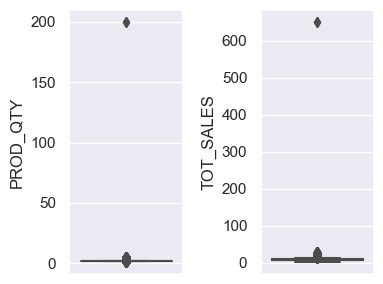

In [12]:
sns.set_theme()
fig, ax = plt.subplots(ncols=2, figsize=(4,3))

sns.boxplot(
    data = transaction_data,
    y = 'PROD_QTY',
    ax=ax[0]
)
sns.boxplot(
    data = transaction_data,
    y = 'TOT_SALES',
    ax=ax[1]
)
fig.tight_layout()


Indeed the outliers is this transaction (or multiplie transactions) for 200 units of chips.
Let's get futher details:

In [13]:
transaction_data[transaction_data['PROD_QTY'] == 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


The same customer made both transactions.
Did they make others?

In [14]:
transaction_data[transaction_data['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


No, they only made these two very large purchases.
It is safe to remove these transactions from the dataset as this customers behaviour is very out of the ordinary.

In [15]:
# Remove outlier customer
transaction_data = transaction_data[~(transaction_data['LYLTY_CARD_NBR'] == 226000)]

transaction_data.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,248198.000000,2.481980e+05,2.481980e+05,248198.000000,248198.000000,248198.000000
mean,135.056149,1.355341e+05,1.351359e+05,56.397139,1.906357,7.303106
std,76.782904,8.068877e+04,7.814229e+04,33.601203,0.342621,2.474547
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001800e+04,6.758525e+04,27.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030850e+05,2.026598e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000


The dataset now looks much more reasonable.

Now we'll look at the transaction counts by date to make sure there isn't any missing data.

In [16]:
transaction_data['DATE'].nunique()

364

We have a year worth of data, so it seems like we're missing a day.
Which day?

In [17]:
# Create sequence of date
all_dates = list(pd.to_datetime(range(365), unit='D', origin='2018-07-01'))
missing_date = [dt for dt in all_dates if dt not in transaction_data['DATE'].unique()][0]

missing_date

Timestamp('2018-12-25 00:00:00')

So we're missing Christmas. 
This makes sense, since shops aren't open on Christmas.

Now, let's start creating new features to use in our analysis: pack size and brand name.

It seems like all of the product names end with the pack size, so let's check if this is true.


In [18]:
endswithpacksize = transaction_data['PROD_NAME'].str.lower().str.endswith("g")
transaction_data[~endswithpacksize]['PROD_NAME'].unique()

array(['Kettle 135g Swt Pot Sea Salt'], dtype=object)

They all do except for these Kettle chips.
We'll need to deal with this separately.

In [19]:
# Make column for pack size
kettle_135 = transaction_data['PROD_NAME'].str.startswith('Kettle 135g')

# Slice out pack size
transaction_data.loc[~kettle_135, 'PACK_SIZE'] = transaction_data['PROD_NAME'].str[-4:-1]

# Manually set pack size for kettles chips
transaction_data.loc[kettle_135, 'PACK_SIZE'] = '135'

# Change pack size to int
transaction_data['PACK_SIZE'] = transaction_data['PACK_SIZE'].astype('int')

transaction_data.head()


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150


The brand names are usually the first word of the product name, so let's start by doing this.

In [20]:
# Make column for brand names. 
transaction_data['BRAND_NAME'] = transaction_data['PROD_NAME'].str.split(' ').str[0]

transaction_data['BRAND_NAME'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

This is imperfect, for example 'RRD' and 'Red Rock Deli' are the same brand.
Moreover, some brand names have more than one word.
We need to manually rectify all this.

In [21]:
# The brand names to correct
corrections = {'Natural':'Natural Chip Company',
    'Red':'Red Rock Deli',
    'RRD':'Red Rock Deli',
    'Old':'Old El Paso',
    'Grain':'Grain Waves',
    'WW':'Woolworths',
    'Burger':'Burger Rings',
    'French':'French Fries',
    'NCC':'Natural Chip Company'     ,
    'GrnWves':'Grain Waves',
    'Snbts':'Sunbites',
    'Infzns':'Infuzions',
    'Smith': 'Smiths'}

# Apply corrections to brand names
for k in corrections.keys():
    transaction_data.loc[transaction_data['BRAND_NAME'] == k, 'BRAND_NAME'] = corrections[k]

transaction_data['BRAND_NAME'].unique()

array(['Natural Chip Company', 'CCs', 'Smiths', 'Kettle', 'Grain Waves',
       'Doritos', 'Twisties', 'Woolworths', 'Thins', 'Burger Rings',
       'Cheezels', 'Infuzions', 'Red Rock Deli', 'Pringles', 'Dorito',
       'Tyrrells', 'Cobs', 'French Fries', 'Tostitos', 'Cheetos',
       'Sunbites'], dtype=object)

### Customer Data

In [22]:
# Load customer data
purchasing_bhvr = pd.read_csv('data/QVI_purchase_behaviour.csv')

print(purchasing_bhvr.shape)
purchasing_bhvr.head()

(72637, 3)


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [23]:
purchasing_bhvr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


We can see that there are no null values in the dataset.

In [24]:
purchasing_bhvr['LIFESTAGE'].value_counts(normalize=True) * 100

RETIREES                  20.382174
OLDER SINGLES/COUPLES     20.112339
YOUNG SINGLES/COUPLES     19.881052
OLDER FAMILIES            13.464212
YOUNG FAMILIES            12.635434
MIDAGE SINGLES/COUPLES    10.015557
NEW FAMILIES               3.509231
Name: LIFESTAGE, dtype: float64

In [25]:
purchasing_bhvr['PREMIUM_CUSTOMER'].value_counts(normalize=True) * 100

Mainstream    40.261850
Budget        33.688065
Premium       26.050085
Name: PREMIUM_CUSTOMER, dtype: float64

There are seven 'lifestages' and three price points.

Overall the dataset is in good shape and there doesn't appear to be any cleaning or processing to be done.

Let's get an overview of the data with some visualisations.

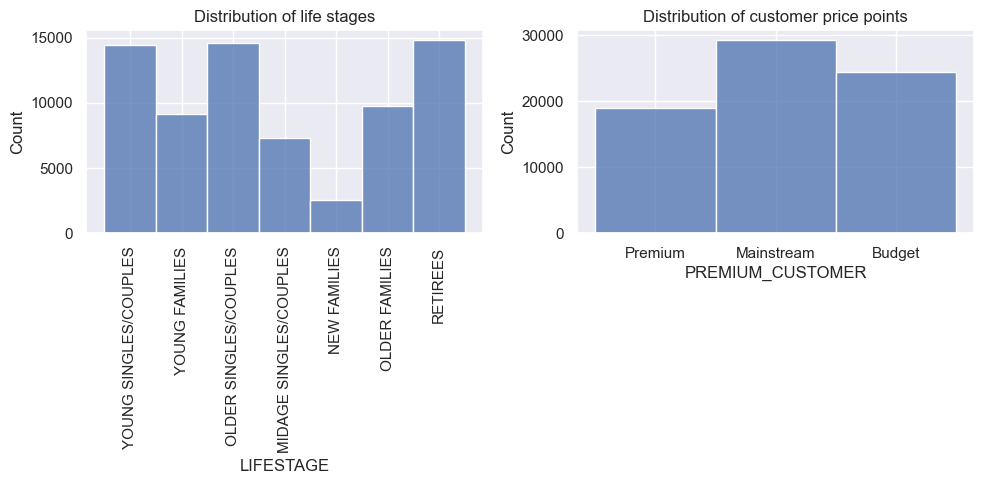

In [26]:
# Frequency bar chart for lifestage
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.histplot(
    data = purchasing_bhvr,
    x= 'LIFESTAGE',
    ax=ax[0]
)
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("Distribution of life stages")

sns.histplot(
    data = purchasing_bhvr,
    x= 'PREMIUM_CUSTOMER',
    ax=ax[1]
)
ax[1].set_title("Distribution of customer price points")

fig.tight_layout()

<p align='justify'>
We can see that more retirees are chip customers than any other demographic, closely followed by older singles/couples and young singles/couples.
New families are the least likely to be buying chips.
Overall, singles and couples are more likely to be buying chips than families, except for some reason middle ages singles and couples fall behind.
</p>

We can see the differences in the customer segmentation for each price point:

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'YOUNG SINGLES/COUPLES'),
  Text(1, 0, 'NEW FAMILIES'),
  Text(2, 0, 'OLDER SINGLES/COUPLES'),
  Text(3, 0, 'MIDAGE SINGLES/COUPLES'),
  Text(4, 0, 'OLDER FAMILIES'),
  Text(5, 0, 'RETIREES'),
  Text(6, 0, 'YOUNG FAMILIES')])

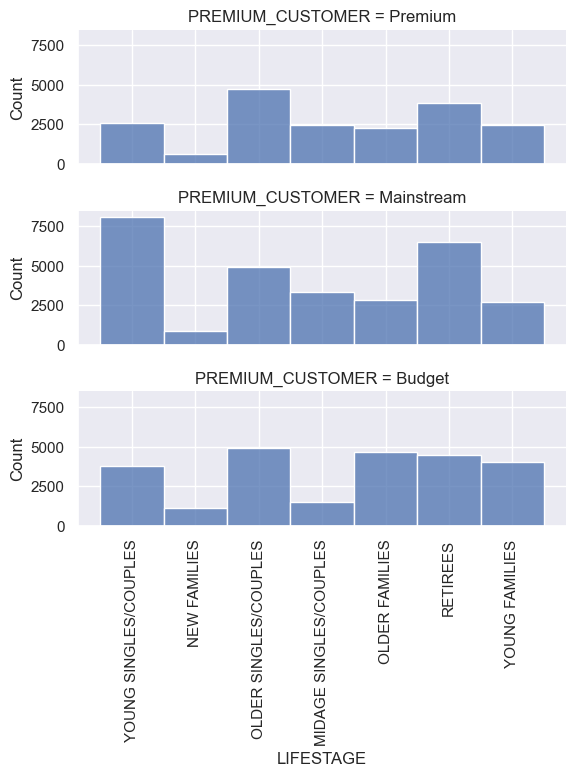

In [27]:
g = sns.FacetGrid(purchasing_bhvr, row='PREMIUM_CUSTOMER', height=2, aspect=3)
g.map_dataframe(sns.histplot, x="LIFESTAGE")
plt.xticks(rotation=90)

New families, older families, and young famiiles are more likely to be buying budget chips then premium chips over the other two options.
Midage singles/couples and young singles/couples buy mainstream chips the most, the latter being particularly unlikely to be in the premium category.

## Joining dataframes

Before completing our analysis we will join the two tables into one single table.

In [28]:
qvi_data = transaction_data.merge(purchasing_bhvr, on='LYLTY_CARD_NBR', how='inner')

qvi_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural Chip Company,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2018-11-10,1,1307,346,96,WW Original Stacked Chips 160g,2,3.8,160,Woolworths,MIDAGE SINGLES/COUPLES,Budget
3,2019-03-09,1,1307,347,54,CCs Original 175g,1,2.1,175,CCs,MIDAGE SINGLES/COUPLES,Budget
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget


## Data Analysis on Customer Segments

Define some metrics of interest to our client.

Start by calculating total sales for each customer segment.

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'MIDAGE SINGLES/COUPLES'),
  Text(1, 0, 'NEW FAMILIES'),
  Text(2, 0, 'OLDER FAMILIES'),
  Text(3, 0, 'OLDER SINGLES/COUPLES'),
  Text(4, 0, 'RETIREES'),
  Text(5, 0, 'YOUNG FAMILIES'),
  Text(6, 0, 'YOUNG SINGLES/COUPLES')])

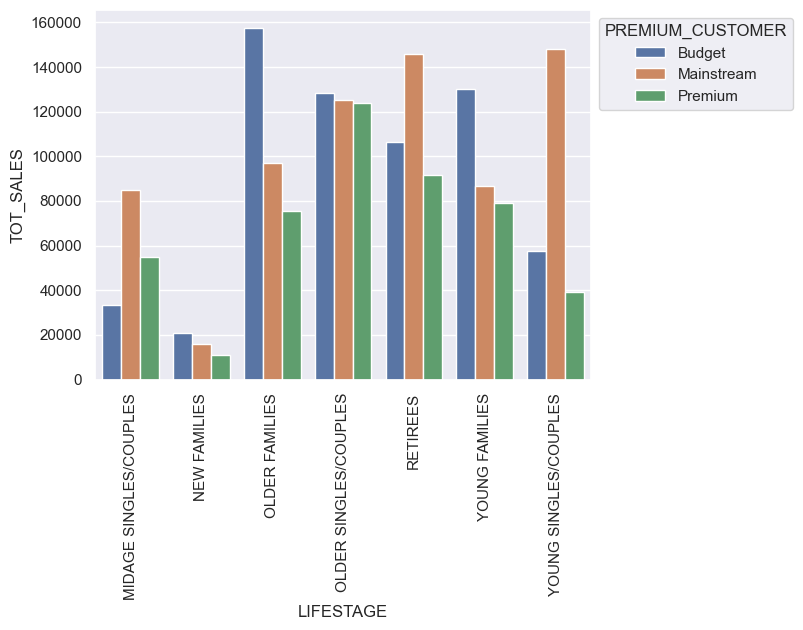

In [29]:
# Total sales by lifestage and premium_customeror

sales_by_segment = qvi_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

g=sns.barplot(
    data = sales_by_segment,
    x='LIFESTAGE',
    y='TOT_SALES',
    hue='PREMIUM_CUSTOMER'
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)

It would be good to quantify this:

In [30]:
sales_by_segment = qvi_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

sales_by_segment['Percent'] = 100*sales_by_segment['TOT_SALES'] / sales_by_segment['TOT_SALES'].sum()
sales_by_segment.sort_values('Percent', ascending=False, inplace=True)
sales_by_segment

,LIFESTAGE,PREMIUM_CUSTOMER,TOT_SALES,Percent
6,OLDER FAMILIES,Budget,157646.75,8.697194
19,YOUNG SINGLES/COUPLES,Mainstream,148030.40,8.166671
13,RETIREES,Mainstream,145806.15,8.043962
15,YOUNG FAMILIES,Budget,130276.85,7.187228
9,OLDER SINGLES/COUPLES,Budget,128254.80,7.075673
10,OLDER SINGLES/COUPLES,Mainstream,125188.50,6.906509
11,OLDER SINGLES/COUPLES,Premium,124026.25,6.842389
12,RETIREES,Budget,106291.60,5.863988
7,OLDER FAMILIES,Mainstream,96805.05,5.340626
14,RETIREES,Premium,91650.35,5.056247


In [40]:
sales_by_segment = qvi_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

sales_by_segment['Percent'] = 100*sales_by_segment['TOT_SALES'] / sales_by_segment['TOT_SALES'].sum()
sales_by_segment.sort_values('Percent', ascending=False, inplace=True)

# Add number of customers
cust_count = qvi_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()
sales_by_segment = sales_by_segment.merge(cust_count, how='inner', on=['LIFESTAGE', 'PREMIUM_CUSTOMER'])

# Add average number of packets bought per customer
avg_qty = qvi_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER', 'LYLTY_CARD_NBR'])['PROD_QTY'].sum().groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).mean().reset_index()
sales_by_segment = sales_by_segment.merge(avg_qty, how='inner', on=['LIFESTAGE', 'PREMIUM_CUSTOMER'])

# Average price per unit sold
qvi_data['unit_price'] = qvi_data['TOT_SALES'] / qvi_data['PROD_QTY']
avg_price = qvi_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['unit_price'].mean()
sales_by_segment = sales_by_segment.merge(avg_price, how='inner', on=['LIFESTAGE', 'PREMIUM_CUSTOMER'])

sales_by_segment.rename(columns={'LYLTY_CARD_NBR':'cust_count', 'PROD_QTY':'avg_qty', 'unit_price':'avg_price'}, inplace=True)
sales_by_segment


,LIFESTAGE,PREMIUM_CUSTOMER,TOT_SALES,Percent,cust_count,avg_qty,avg_price
0,OLDER FAMILIES,Budget,157646.75,8.697194,4617,9.127789,3.738150
1,YOUNG SINGLES/COUPLES,Mainstream,148030.40,8.166671,7921,4.594243,4.059105
2,RETIREES,Mainstream,145806.15,8.043962,6369,5.952740,3.837289
3,YOUNG FAMILIES,Budget,130276.85,7.187228,3957,8.766490,3.754386
4,OLDER SINGLES/COUPLES,Budget,128254.80,7.075673,4856,6.803748,3.876273
5,OLDER SINGLES/COUPLES,Mainstream,125188.50,6.906509,4866,6.742088,3.807847
6,OLDER SINGLES/COUPLES,Premium,124026.25,6.842389,4690,6.796588,3.886590
7,RETIREES,Budget,106291.60,5.863988,4388,6.169325,3.918238
8,OLDER FAMILIES,Mainstream,96805.05,5.340626,2793,9.290727,3.731081
9,RETIREES,Premium,91650.35,5.056247,3817,6.129683,3.914096


Text(0.5, 1.0, 'Number of customers by customer segment')

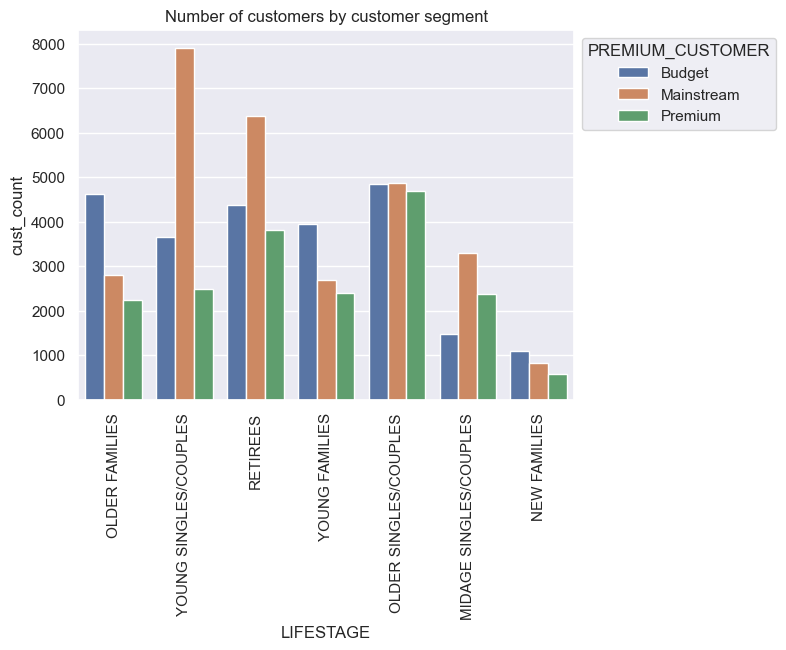

In [36]:
g=sns.barplot(
    data = sales_by_segment,
    x='LIFESTAGE',
    y='cust_count',
    hue='PREMIUM_CUSTOMER'
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
g.set_title("Number of customers by customer segment")

There a more young singles/couples and retirees that buy mainstream cheaps than any other customer segment, which contibutes to them having more sales. However, this does not appear to be a main driver for the older families - budget segment.

Since there are not more customers in this segment, we should see if the customers in this segment are buying more chips on average.

Text(0.5, 1.0, 'Average number of packs bought by each customer by customer segment')

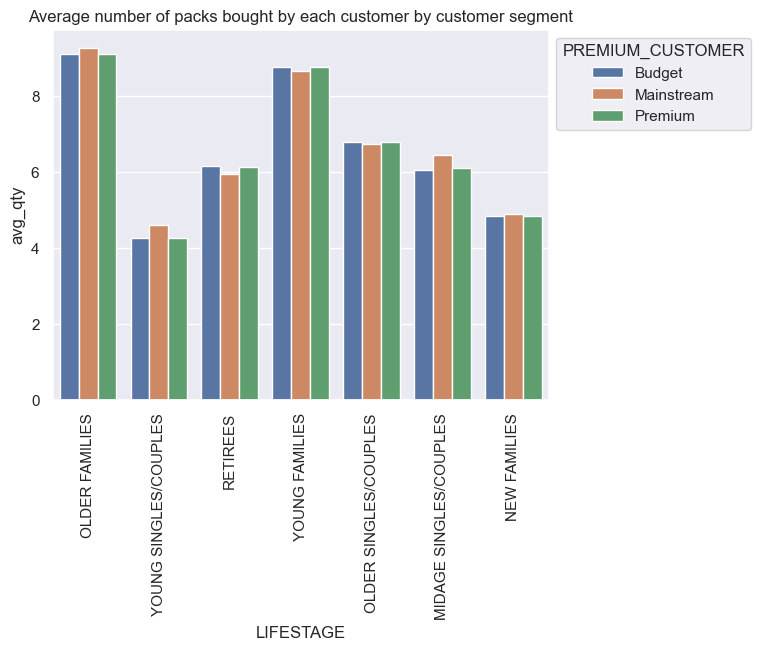

In [37]:
g=sns.barplot(
    data = sales_by_segment,
    x='LIFESTAGE',
    y='avg_qty',
    hue='PREMIUM_CUSTOMER'
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
g.set_title("Average number of packs bought by each customer by customer segment")

Indeed, customers in the older families segment buy the most packets of chips, followed by young families.

Text(0.5, 1.0, 'Average price per unit by customer segment')

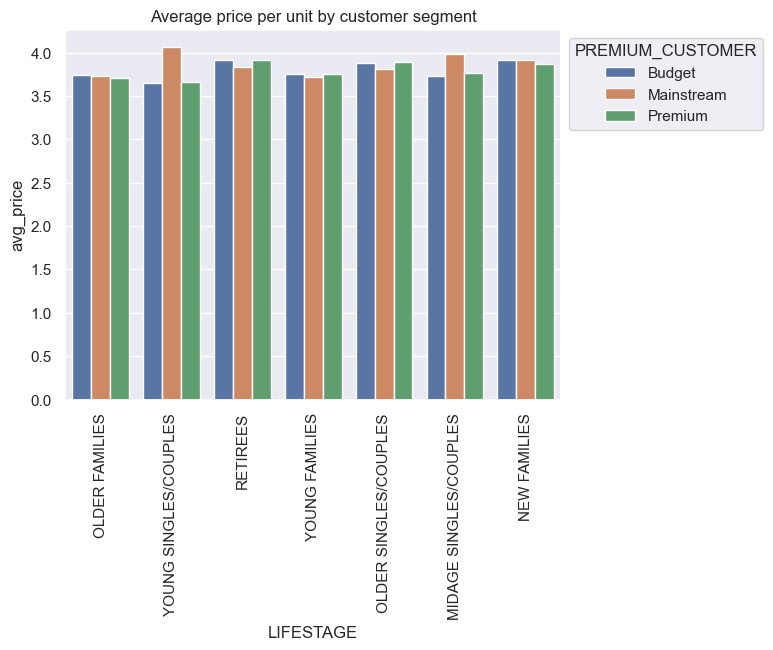

In [43]:
# Average price by customer segment
g=sns.barplot(
    data = sales_by_segment,
    x='LIFESTAGE',
    y='avg_price',
    hue='PREMIUM_CUSTOMER'
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
g.set_title('Average price per unit by customer segment')

Mainstream young singles/couples and midage singles/couples pay more per packet of chips than any other segment.

One might expect that premium shoppers pay more for each packet, but perhaps premium shoppers tend to buy healthier snacks and when they buy chips it is for entertainment purposes.
This is supported by the number of premium customers being less than their mainstream counterpart for each lifestage.

There isn't a large difference between the average unit price for mainstream young and midage singles/couples and their premium conterparts. We'll use a T-test to check this.

In [59]:
# T-test for average unit price between mainsteam and premium young and midage singles/couples.

lifestages = ['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES']
mainstream_avg_price = qvi_data[(qvi_data['LIFESTAGE'].isin(lifestages)) & (qvi_data['PREMIUM_CUSTOMER'] == 'Mainstream')]['unit_price']
premium_avg_price = qvi_data[(qvi_data['LIFESTAGE'].isin(lifestages) ) & (qvi_data['PREMIUM_CUSTOMER'] == 'Premium')]['unit_price']
budget_avg_price = qvi_data[(qvi_data['LIFESTAGE'].isin(lifestages) ) & (qvi_data['PREMIUM_CUSTOMER'] == 'Budget')]['unit_price']

print(ttest_ind(mainstream_avg_price, premium_avg_price))
print(ttest_ind(mainstream_avg_price, budget_avg_price))

Ttest_indResult(statistic=29.375326195685652, pvalue=7.240875877479106e-188)
Ttest_indResult(statistic=32.75850955075396, pvalue=1.428215623861189e-232)


So we can confirm that the difference is statistically significant and that the average unit price is higher for mainstream young and midage singles/couples than for their premium and budget counterparts.

We can look a bit deeper at the customer segments that contribute most to sales. 
The client may want to focus on retaining or increasing sales in this segment.
Let's, for example, look at the mainstream young singles/couples and see which brands they tend to buy.

Text(0.5, 1.0, 'Brand names for mainstream young singles/couples')

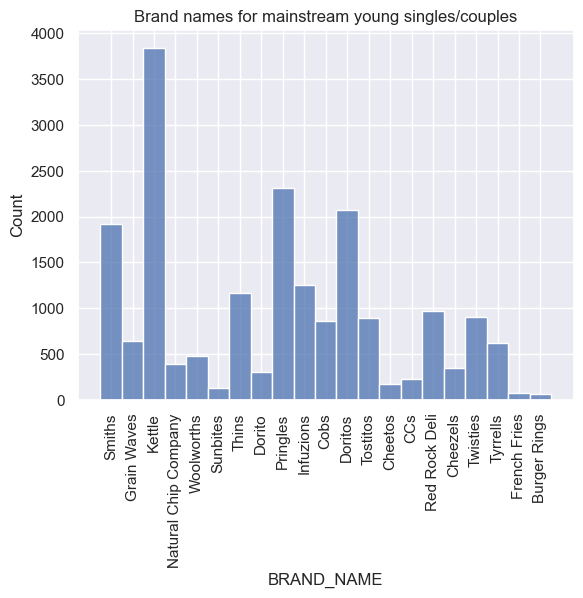

In [79]:
mainstream_young_singles_couples = qvi_data[(qvi_data['LIFESTAGE']=='YOUNG SINGLES/COUPLES' ) & (qvi_data['PREMIUM_CUSTOMER'] == 'Mainstream')].copy()

plt.xticks(rotation=90)
g = sns.histplot(
    data = mainstream_young_singles_couples,
    x = 'BRAND_NAME'
)
g.set_title("Brand names for mainstream young singles/couples")


The most popular brand of chips by far is Kettle chips, followd by Pringles, Doritos, and Smiths.

We can also look at the times of year they buy chips:

Text(0.5, 1.0, 'Total sales per month for mainstream young singles/couples')

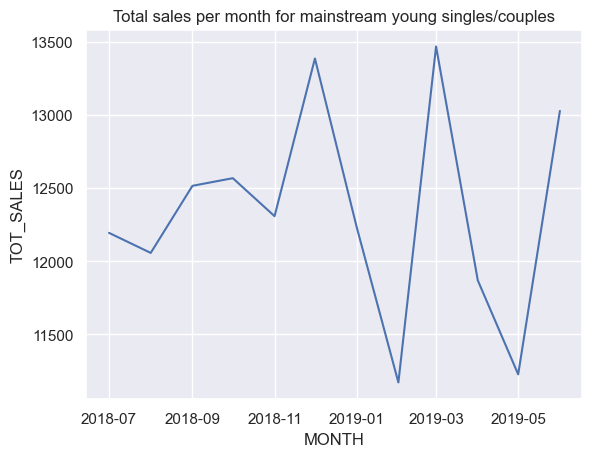

In [80]:
mainstream_young_singles_couples['MONTH'] = pd.PeriodIndex(mainstream_young_singles_couples['DATE'], freq='M').to_timestamp()
monthly_data = mainstream_young_singles_couples.groupby('MONTH').sum(numeric_only=True)

g = sns.lineplot(
    data = monthly_data,
    x = 'MONTH',
    y = 'TOT_SALES'
)
g.set_title("Total sales per month for mainstream young singles/couples")

We see a sharp peak in December, followed by a sharp drop. 
It is clear that December would correspond to Christmas and summer holidays, but we should also investigate the other peaks and compare this pattern with other segments.